<h1><center> || March Madness Notebook || </center></h1>

## Importing the necessary libraries

In [278]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.utils import shuffle

%matplotlib inline
sns.set_style('darkgrid')

## Poking around to see what we have

In [279]:
sample_sub = pd.read_csv('../Datasets/SampleSubmissionStage1.csv')
sample_sub.head(3)

,ID,Pred
0,2014_1107_1110,0.5
1,2014_1107_1112,0.5
2,2014_1107_1113,0.5


So in 2014, team 1107 has 50% chance of beating 1110

In [280]:
teams = pd.read_csv('../Datasets/DataFiles/Teams.csv')
teams.head(5)

,TeamID,TeamName,FirstD1Season,LastD1Season
0,1101,Abilene Chr,2014,2018
1,1102,Air Force,1985,2018
2,1103,Akron,1985,2018
3,1104,Alabama,1985,2018
4,1105,Alabama A&M,2000,2018


In [281]:
slots = pd.read_csv('Stage2UpdatedDataFiles/NCAATourneySlots.csv')
slots.head(3)

,Season,Slot,StrongSeed,WeakSeed
0,1985,R1W1,W01,W16
1,1985,R1W2,W02,W15
2,1985,R1W3,W03,W14


#### **Ok, think I want to know what direction I want to take this in.**

In [282]:
detailed = pd.read_csv('Stage2UpdatedDataFiles/RegularSeasonDetailedResults.csv')
detailed.head(3)

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,68,1328,62,N,0,27,58,...,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,...,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,...,26,14,23,31,22,9,12,2,5,23


In [283]:
detailed.columns

Index(['Season', 'DayNum', 'WTeamID', 'WScore', 'LTeamID', 'LScore', 'WLoc',
       'NumOT', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR',
       'WAst', 'WTO', 'WStl', 'WBlk', 'WPF', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3',
       'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF'],
      dtype='object')

All of the columns with 'W' correspond to the winning team's stat in that category and likewise for all columns with 'L' and the losing team.

- WFGM - field goals made (by the winning team)
- WFGA - field goals attempted (by the winning team)
- WFGM3 - three pointers made (by the winning team)
- WFGA3 - three pointers attempted (by the winning team)
- WFTM - free throws made (by the winning team)
- WFTA - free throws attempted (by the winning team)
- WOR - offensive rebounds (pulled by the winning team)
- WDR - defensive rebounds (pulled by the winning team)
- WAst - assists (by the winning team)
- WTO - turnovers committed (by the winning team)
- WStl - steals (accomplished by the winning team)
- WBlk - blocks (accomplished by the winning team)
- WPF - personal fouls committed (by the winning team)

Ultimately I'm actually going to drop all the seasons from before 2006. 2006 was when the "one-and-done" rule was implemented and the game changed significantly after.

Plus some of the biggest upsets in tournament history have been in 2006 - current, so there may be something to learn from those seasons.

#### Strategy pivot: Going to be digging only into this season's stats since I believe that the turnover rate is high enough in NCAA basketball that each season now is basically an independent event.

In [284]:
detailed = detailed.loc[detailed.Season == 2018, :]
detailed.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
76636,2018,11,1104,82,1272,70,N,0,26,57,...,17,22,36,19,24,7,17,7,3,22
76637,2018,11,1107,69,1233,67,H,0,24,62,...,22,11,14,7,20,14,7,6,3,21
76638,2018,11,1112,101,1319,67,H,0,34,57,...,13,17,30,12,11,11,13,3,1,24
76639,2018,11,1113,94,1226,74,H,0,34,65,...,24,13,22,8,21,17,14,6,2,20
76640,2018,11,1116,95,1359,56,H,0,36,63,...,29,8,15,15,17,12,19,6,1,20


#### Cool. So I learned from the Ames project that intelligent feature engineering is a HUGE part of model success.
 With that in mind, I'm not going to try to reinvent the wheel or anything, I want to incorporate a couple of the advanced
 team analytics that are currently being used in the game today.

# // Feature engineering //

References for these available below.
- Quick overview:
    - https://stats.nba.com/help/faq/
- Deeper dive:
    - http://hangtime.blogs.nba.com/2013/02/15/the-new-nba-comstats-advanced-stats-all-start-with-pace-and-efficiency/
- Actual glossary + formulas:
    - https://stats.nba.com/help/glossary/

In [285]:
# To make all of the calculations easier to read, let's assign some variables:

W_Score = detailed.WScore
W_FGM   = detailed.WFGM
W_FGA   = detailed.WFGA
W_FGM3  = detailed.WFGM3
W_FGA3  = detailed.WFGA3
W_FTM   = detailed.WFTM
W_FTA   = detailed.WFTA
W_OReb  = detailed.WOR
W_DReb  = detailed.WDR
W_Ast   = detailed.WAst
W_TO    = detailed.WTO
W_Steal = detailed.WStl
W_Block = detailed.WBlk
W_Fouls = detailed.WPF

In [286]:
L_Score = detailed.LScore
L_FGM   = detailed.LFGM
L_FGA   = detailed.LFGA
L_FGM3  = detailed.LFGM3
L_FGA3  = detailed.LFGA3
L_FTM   = detailed.LFTM
L_FTA   = detailed.LFTA
L_OReb  = detailed.LOR
L_DReb  = detailed.LDR
L_Ast   = detailed.LAst
L_TO    = detailed.LTO
L_Steal = detailed.LStl
L_Block = detailed.LBlk
L_Fouls = detailed.LPF

### Starting with some building block efficiencies and possession stats

**Basic Possession Formula:**
- 0.96 x (( Field Goal Attempts ) + ( Turnovers ) + ( 0.44 x Free Throw Attempts ) - ( Offensive Rebounds )) 

In [287]:
detailed['W_Pos'] = .96 * (W_FGA + W_TO + (.44 * W_FTA) - W_OReb)
detailed['L_Pos'] = .96 * (L_FGA + L_TO + (.44 * L_FTA) - L_OReb)

**Offensive Efficiency Rating:**
- 100 x ( Points / Possessions )

In [288]:
detailed['W_Off_Rtg'] = 100 * (W_Score / detailed.W_Pos)
detailed['L_Off_Rtg'] = 100 * (L_Score / detailed.L_Pos)

**Defensive Efficiency Rating:**
- 100 x ( Opponent Points / Opponent Possessions )

In [289]:
detailed['W_Def_Rtg'] = detailed.L_Off_Rtg
detailed['L_Def_Rtg'] = detailed.W_Off_Rtg

 ### **"Four Factors"** are the box score derived metrics that correlate most closely with winning basketball games. 

**1. Shooting the Ball**
- Effective Field Goal Percentage = ( Field Goals Made + ( 0.5 x 3P Field Goals Made )) / ( Field Goal Attempts )

In [290]:
detailed['W_Eff_FG'] = (W_FGM + (.5 * W_FGM3)) / W_FGA
detailed['L_Eff_FG'] = (L_FGM + (.5 * L_FGM3)) / L_FGA

**2. Taking Care of the Ball**
- Turnover Rate = Turnovers / ( Field Goal Attempts + ( 0.44 x Free Throw Attempts ) + Turnovers )

In [291]:
detailed['W_TOR'] = W_TO / (W_FGA + (.44 * W_FTA) + W_TO)
detailed['L_TOR'] = L_TO / (L_FGA + (.44 * L_FTA) + L_TO)

In [292]:
# Checking to see that intuition should still hold up
detailed.W_TOR.mean() < detailed.L_TOR.mean()

True

**3. Offensive Rebounding**
- Offensive Rebounding Percentage = ( Offensive Rebounds ) / ( ( Offensive Rebounds ) + ( Opponent’s Defensive Rebounds ) )

In [293]:
detailed['W_ORP'] = W_OReb / (W_OReb + L_DReb)
detailed['L_ORP'] = L_OReb / (L_OReb + W_DReb)

**4. Getting to the Foul Line**
- Free Throw Rate = ( Free Throws Made ) / ( Field Goals Attempted )

In [294]:
detailed['W_FTR'] = W_FTM / W_FGA
detailed['L_FTR'] = L_FTM / L_FGA

In [295]:
detailed.head(3)

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,W_Def_Rtg,L_Def_Rtg,W_Eff_FG,L_Eff_FG,W_TOR,L_TOR,W_ORP,L_ORP,W_FTR,L_FTR
76636,2018,11,1104,82,1272,70,N,0,26,57,...,98.749549,118.109329,0.552632,0.400000,0.187529,0.183111,0.351351,0.413043,0.333333,0.366667
76637,2018,11,1107,69,1233,67,H,0,24,62,...,107.108144,111.676507,0.419355,0.474576,0.155950,0.097007,0.487179,0.200000,0.274194,0.186441
76638,2018,11,1112,101,1319,67,H,0,34,57,...,96.664358,150.126046,0.640351,0.431034,0.134016,0.154394,0.521739,0.279070,0.491228,0.293103


### Save room for PIE

What is **PIE**?

It is a simple metric that gives an excellent indication of performance at both the team and player level. It’s a major improvement to an EFF Rating.

The key here is the denominator because it acts as an "automatic equalizer". In its simplest terms, PIE shows what % of game events did that player or team achieve. 

The stats being analyzed are your traditional basketball statistics (PTS, REB, AST, TOV, etc..) _**A team that achieves more than 50% is likely to be a winning team.**_ In fact, a team’s PIE rating and a team’s winning percentage correlate at an R square of .908 which indicates a "strong" correlation.

( PTS + FGM + FTM - FGA - FTA + DREB + ( .5 x OREB ) + AST + STL + ( .5 x BLK ) - PF - TO ) 

**__DIVIDED BY__**

( GmPTS + GmFGM + GmFTM - GmFGA - GmFTA + GmDREB + ( .5 x GmOREB ) + GmAST + GmSTL + ( .5 x GmBLK ) - GmPF - GmTO )

In [296]:
W_numerator = W_Score + W_FGM + W_FTM - W_FGA - W_FTA + W_DReb + (.5 *W_OReb) + W_Ast + W_Steal + (.5 * W_Block) - W_Fouls - W_TO
L_numerator = L_Score + L_FGM + L_FTM - L_FGA - L_FTA + L_DReb + (.5 *L_OReb) + L_Ast + L_Steal + (.5 * L_Block) - L_Fouls - L_TO
game_totals = (W_Score + L_Score) + (W_FGM + L_FGM) + (W_FTM + L_FTM) - (W_FGA + L_FGA) - (W_FTA + L_FTA) + (W_DReb + L_DReb) + (.5 * (W_OReb + L_OReb)) + (W_Ast + L_Ast) + (W_Steal + L_Steal) + (.5 * (W_Block + L_Block)) - (W_Fouls + L_Fouls) - (W_TO + L_TO)

detailed['W_PIE'] = W_numerator / game_totals
detailed['L_PIE'] = L_numerator / game_totals

print(detailed.W_PIE.mean())
print(detailed.L_PIE.mean())

0.6329131306655542
0.36708686933444373


In [297]:
detailed.head(3)

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,W_Eff_FG,L_Eff_FG,W_TOR,L_TOR,W_ORP,L_ORP,W_FTR,L_FTR,W_PIE,L_PIE
76636,2018,11,1104,82,1272,70,N,0,26,57,...,0.552632,0.400000,0.187529,0.183111,0.351351,0.413043,0.333333,0.366667,0.662791,0.337209
76637,2018,11,1107,69,1233,67,H,0,24,62,...,0.419355,0.474576,0.155950,0.097007,0.487179,0.200000,0.274194,0.186441,0.481081,0.518919
76638,2018,11,1112,101,1319,67,H,0,34,57,...,0.640351,0.431034,0.134016,0.154394,0.521739,0.279070,0.491228,0.293103,0.887967,0.112033


**Don't forget to come up with a consistency rating if you have time!!**

**Don't forget to make a "difficulty by seed" feature!!!**

Very interesting to think about the difficulty of the path to the final that way, though I would've probably tried to weigh it by the probability that your team will face that seed in the next round instead of just assuming you will face the higher seed.

i mean use bayes - instead of saying the 5 auto plays the 4 next round say they get 12*probability 5 will win + 5* probability 12 will win

_ Also put in some VIZZZZ here to show the advanced stats that we've got now _

## Now manipulating the structure of our data so we can have something to train the model on

In [298]:
games = []
for row in detailed.to_dict('records'):
    
    game = {}
    game['Season']      = row['Season']
    game['TeamID']     = row['WTeamID']
    game['OpponentID']  = row['LTeamID']
    game['Pos']         = row['W_Pos']
    game['Off_Rtg']     = row['W_Off_Rtg']
    game['Def_Rtg']     = row['W_Def_Rtg']
    game['Eff_FG']      = row['W_Eff_FG']
    game['TOR']         = row['W_TOR']
    game['ORP']         = row['W_ORP']
    game['FTR']         = row['W_FTR']
    game['PIE']         = row['W_PIE']
    game['Won']         = 1
    
    game['Pos_dif']     = row['W_Pos'] - row['L_Pos']
    game['Off_Rtg_dif'] = row['W_Off_Rtg'] - row['L_Off_Rtg']
    game['Def_Rtg_dif'] = row['W_Def_Rtg'] - row['L_Def_Rtg']
    game['Eff_FG_dif']  = row['W_Eff_FG'] - row['L_Eff_FG']
    game['TOR_dif']     = row['W_TOR'] - row['L_TOR']
    game['ORP_dif']     = row['W_ORP'] - row['L_ORP']
    game['FTR_dif']     = row['W_FTR'] - row['L_FTR']
    game['PIE_dif']     = row['W_PIE'] - row['L_PIE']
    
    games.append(game)
    
    # Break
    
    game = {}
    game['Season']      = row['Season']
    game['TeamID']      = row['LTeamID']
    game['OpponentID']  = row['WTeamID']
    game['Pos']         = row['L_Pos']
    game['Off_Rtg']     = row['L_Off_Rtg']
    game['Def_Rtg']     = row['L_Def_Rtg']
    game['Eff_FG']      = row['L_Eff_FG']
    game['TOR']         = row['L_TOR']
    game['ORP']         = row['L_ORP']
    game['FTR']         = row['L_FTR']
    game['PIE']         = row['L_PIE']
    game['Won']         = 0
    
    game['Pos_dif']     = row['L_Pos'] - row['W_Pos']
    game['Off_Rtg_dif'] = row['L_Off_Rtg'] - row['W_Off_Rtg']
    game['Def_Rtg_dif'] = row['L_Def_Rtg'] - row['W_Def_Rtg']
    game['Eff_FG_dif']  = row['L_Eff_FG'] - row['W_Eff_FG']
    game['TOR_dif']     = row['L_TOR'] - row['W_TOR']
    game['ORP_dif']     = row['L_ORP'] - row['W_ORP']
    game['FTR_dif']     = row['L_FTR'] - row['W_FTR']
    game['PIE_dif']     = row['L_PIE'] - row['W_PIE']
    
    games.append(game)

games_df = pd.DataFrame(games)
games_df.head(4)

,Def_Rtg,Def_Rtg_dif,Eff_FG,Eff_FG_dif,FTR,FTR_dif,ORP,ORP_dif,Off_Rtg,Off_Rtg_dif,OpponentID,PIE,PIE_dif,Pos,Pos_dif,Season,TOR,TOR_dif,TeamID,Won
0,98.749549,-19.359780,0.552632,0.152632,0.333333,-0.033333,0.351351,-0.061692,118.109329,19.359780,1272,0.662791,0.325581,69.4272,-1.4592,2018,0.187529,0.004419,1104,1
1,118.109329,19.359780,0.400000,-0.152632,0.366667,0.033333,0.413043,0.061692,98.749549,-19.359780,1104,0.337209,-0.325581,70.8864,1.4592,2018,0.183111,-0.004419,1272,0
2,107.108144,-4.568363,0.419355,-0.055221,0.274194,0.087753,0.487179,0.287179,111.676507,4.568363,1233,0.481081,-0.037838,61.7856,-0.7680,2018,0.155950,0.058943,1107,1
3,111.676507,4.568363,0.474576,0.055221,0.186441,-0.087753,0.200000,-0.287179,107.108144,-4.568363,1107,0.518919,0.037838,62.5536,0.7680,2018,0.097007,-0.058943,1233,0


In [299]:
# Just doing a quick check to make sure that we have everything duplicated aka from both perspectives.
games_df.shape[0] == (2 * detailed.shape[0])

True

In [300]:
games_df.corr().loc['Won', :].sort_values(ascending = False)

Won            1.000000
Off_Rtg_dif    0.802438
PIE_dif        0.789605
PIE            0.789605
Eff_FG_dif     0.677166
Off_Rtg        0.581066
Eff_FG         0.492607
FTR_dif        0.409038
FTR            0.278763
ORP_dif        0.229220
ORP            0.162071
TeamID         0.058640
Pos           -0.024311
OpponentID    -0.058640
TOR           -0.145443
Pos_dif       -0.163480
TOR_dif       -0.212207
Def_Rtg       -0.581066
Def_Rtg_dif   -0.802438
Season              NaN
Name: Won, dtype: float64

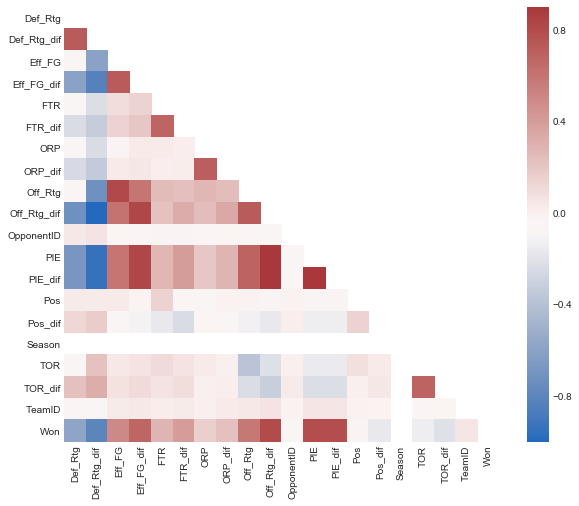

In [301]:
plt.figure(figsize=(10,8))

corr = games_df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(corr, mask=mask, vmax=.9, square=True, cmap='vlag')
plt.savefig('analytics_effect.png')

**SO. Now I want to get the season long averages and average differentials for each team. Then join those back into these regular season match-ups then train the model on those.**

In [302]:
summary_stats = games_df.groupby('TeamID').mean()
summary_stats = summary_stats.add_suffix('_avg')
summary_stats.drop(['OpponentID_avg', 'Season_avg', 'Won_avg'], axis=1, inplace=True)
summary_stats.reset_index(level=0, inplace=True)
summary_stats.head(3)

,TeamID,Def_Rtg_avg,Def_Rtg_dif_avg,Eff_FG_avg,Eff_FG_dif_avg,FTR_avg,FTR_dif_avg,ORP_avg,ORP_dif_avg,Off_Rtg_avg,Off_Rtg_dif_avg,PIE_avg,PIE_dif_avg,Pos_avg,Pos_dif_avg,TOR_avg,TOR_dif_avg
0,1101,108.369964,3.027014,0.510697,-0.008713,0.240944,-0.074223,0.262368,-0.031703,105.342950,-3.027014,0.471247,-0.057506,67.262578,-0.098133,0.181402,-0.011258
1,1102,112.635920,9.150306,0.474561,-0.077822,0.242446,0.001532,0.271192,-0.014643,103.485615,-9.150306,0.444632,-0.110735,64.247172,-0.286014,0.165710,-0.018128
2,1103,114.718531,7.404159,0.515700,-0.025224,0.223778,-0.062406,0.271276,-0.011190,107.314372,-7.404159,0.436364,-0.127272,66.445626,0.068129,0.174633,0.009458


### Bringing those season-long summary stats back into the main dataframe.

In [303]:
df = pd.merge(games_df, summary_stats, on='TeamID')

In [304]:
df = pd.merge(df, summary_stats, left_on='OpponentID', right_on='TeamID')

In [305]:
df.isnull().sum()

Def_Rtg              0
Def_Rtg_dif          0
Eff_FG               0
Eff_FG_dif           0
FTR                  0
FTR_dif              0
ORP                  0
ORP_dif              0
Off_Rtg              0
Off_Rtg_dif          0
OpponentID           0
PIE                  0
PIE_dif              0
Pos                  0
Pos_dif              0
Season               0
TOR                  0
TOR_dif              0
TeamID_x             0
Won                  0
Def_Rtg_avg_x        0
Def_Rtg_dif_avg_x    0
Eff_FG_avg_x         0
Eff_FG_dif_avg_x     0
FTR_avg_x            0
FTR_dif_avg_x        0
ORP_avg_x            0
ORP_dif_avg_x        0
Off_Rtg_avg_x        0
Off_Rtg_dif_avg_x    0
PIE_avg_x            0
PIE_dif_avg_x        0
Pos_avg_x            0
Pos_dif_avg_x        0
TOR_avg_x            0
TOR_dif_avg_x        0
TeamID_y             0
Def_Rtg_avg_y        0
Def_Rtg_dif_avg_y    0
Eff_FG_avg_y         0
Eff_FG_dif_avg_y     0
FTR_avg_y            0
FTR_dif_avg_y        0
ORP_avg_y  

# // Setting up and running the model

In [306]:
train = df.loc[games_df['Season'] >= 2018, :]
print(train.columns)
print(train.shape)

Index(['Def_Rtg', 'Def_Rtg_dif', 'Eff_FG', 'Eff_FG_dif', 'FTR', 'FTR_dif',
       'ORP', 'ORP_dif', 'Off_Rtg', 'Off_Rtg_dif', 'OpponentID', 'PIE',
       'PIE_dif', 'Pos', 'Pos_dif', 'Season', 'TOR', 'TOR_dif', 'TeamID_x',
       'Won', 'Def_Rtg_avg_x', 'Def_Rtg_dif_avg_x', 'Eff_FG_avg_x',
       'Eff_FG_dif_avg_x', 'FTR_avg_x', 'FTR_dif_avg_x', 'ORP_avg_x',
       'ORP_dif_avg_x', 'Off_Rtg_avg_x', 'Off_Rtg_dif_avg_x', 'PIE_avg_x',
       'PIE_dif_avg_x', 'Pos_avg_x', 'Pos_dif_avg_x', 'TOR_avg_x',
       'TOR_dif_avg_x', 'TeamID_y', 'Def_Rtg_avg_y', 'Def_Rtg_dif_avg_y',
       'Eff_FG_avg_y', 'Eff_FG_dif_avg_y', 'FTR_avg_y', 'FTR_dif_avg_y',
       'ORP_avg_y', 'ORP_dif_avg_y', 'Off_Rtg_avg_y', 'Off_Rtg_dif_avg_y',
       'PIE_avg_y', 'PIE_dif_avg_y', 'Pos_avg_y', 'Pos_dif_avg_y', 'TOR_avg_y',
       'TOR_dif_avg_y'],
      dtype='object')
(10810, 53)


In [307]:
new_features = [col for col in train.columns if col not in ['TeamID', 'OpponentID', 'Won', 'TeamID_x', 'TeamID_y', 'Season']]
new_features = [x for x in new_features if 'avg' in str(x)]

In [308]:
X = train[new_features]
y = train['Won']
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state = 23)

In [56]:
rf = RandomForestClassifier(random_state=44)

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Method of selecting samples for training each tree
bootstrap = [True, False]

rf_params = {
    'n_estimators': n_estimators,
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_depth': max_depth,
    'max_features': ['auto', 'log2'],
    'bootstrap': bootstrap
}
rs_rf = RandomizedSearchCV(rf, rf_params)
rs_rf.fit(X_train, y_train)
print (rs_rf.best_score_)
rs_rf.best_params_

0.708646848402615


{'bootstrap': False,
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'log2',
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 600}

In [309]:
rs_rf.score(X_val, y_val)

0.6833148353681096

My original best params. I forgot to pickle but wanted to make sure my bracket and predictions here were the same as my Kaggle submission.

'bootstrap': True,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'log2',
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'n_estimators': 200

In [310]:
rs_rf = RandomForestClassifier(random_state=44, bootstrap=True, criterion='gini', max_depth=None, max_features='log2', min_samples_leaf=4, min_samples_split=10, n_estimators=200)
rs_rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=44, verbose=0, warm_start=False)

In [311]:
rs_rf.score(X_val, y_val)

0.6833148353681096

# // Building out the predictions for the actual tournament!

In [312]:
sample_sub2 = pd.read_csv('Stage2UpdatedDataFiles/SampleSubmissionStage2.csv')
sample_sub2.shape

(2278, 2)

In [313]:
# Starting to build out my "true test" to make predictions

test = pd.read_csv('Stage2UpdatedDataFiles/SampleSubmissionStage2.csv')
display(test.head())
print(test.shape)

,ID,Pred
0,2018_1104_1112,0.5
1,2018_1104_1113,0.5
2,2018_1104_1116,0.5
3,2018_1104_1120,0.5
4,2018_1104_1137,0.5


(2278, 2)


In [314]:
test['Season']     = test['ID'].apply(lambda ID: int(ID.split('_')[0]))
test['TeamID']     = test['ID'].apply(lambda ID: int(ID.split('_')[1]))
test['OpponentID'] = test['ID'].apply(lambda ID: int(ID.split('_')[2]))

test.head(3)

,ID,Pred,Season,TeamID,OpponentID
0,2018_1104_1112,0.5,2018,1104,1112
1,2018_1104_1113,0.5,2018,1104,1113
2,2018_1104_1116,0.5,2018,1104,1116


In [315]:
potential_games = []
for row in test.to_dict('records'):
    
    game = {}
    game['Season']     = row['Season']
    game['TeamID']     = row['TeamID']
    game['OpponentID'] = row['OpponentID']
    
    potential_games.append(game)
    
    # Break
    
    game = {}
    game['Season']     = row['Season']
    game['TeamID']     = row['OpponentID']
    game['OpponentID'] = row['TeamID']
    
    potential_games.append(game)

tourney = pd.DataFrame(potential_games)
tourney.head(4)

,OpponentID,Season,TeamID
0,1112,2018,1104
1,1104,2018,1112
2,1113,2018,1104
3,1104,2018,1113


In [316]:
# Checking to make sure that worked...
print(tourney.shape[0] / sample_sub2.shape[0] == 2)
print(tourney.shape)

True
(4556, 3)


In [317]:
tourney = pd.merge(tourney, summary_stats, on='TeamID')
tourney.columns

Index(['OpponentID', 'Season', 'TeamID', 'Def_Rtg_avg', 'Def_Rtg_dif_avg',
       'Eff_FG_avg', 'Eff_FG_dif_avg', 'FTR_avg', 'FTR_dif_avg', 'ORP_avg',
       'ORP_dif_avg', 'Off_Rtg_avg', 'Off_Rtg_dif_avg', 'PIE_avg',
       'PIE_dif_avg', 'Pos_avg', 'Pos_dif_avg', 'TOR_avg', 'TOR_dif_avg'],
      dtype='object')

In [318]:
tourney = pd.merge(tourney, summary_stats, left_on='OpponentID', right_on='TeamID')
tourney.columns

Index(['OpponentID', 'Season', 'TeamID_x', 'Def_Rtg_avg_x',
       'Def_Rtg_dif_avg_x', 'Eff_FG_avg_x', 'Eff_FG_dif_avg_x', 'FTR_avg_x',
       'FTR_dif_avg_x', 'ORP_avg_x', 'ORP_dif_avg_x', 'Off_Rtg_avg_x',
       'Off_Rtg_dif_avg_x', 'PIE_avg_x', 'PIE_dif_avg_x', 'Pos_avg_x',
       'Pos_dif_avg_x', 'TOR_avg_x', 'TOR_dif_avg_x', 'TeamID_y',
       'Def_Rtg_avg_y', 'Def_Rtg_dif_avg_y', 'Eff_FG_avg_y',
       'Eff_FG_dif_avg_y', 'FTR_avg_y', 'FTR_dif_avg_y', 'ORP_avg_y',
       'ORP_dif_avg_y', 'Off_Rtg_avg_y', 'Off_Rtg_dif_avg_y', 'PIE_avg_y',
       'PIE_dif_avg_y', 'Pos_avg_y', 'Pos_dif_avg_y', 'TOR_avg_y',
       'TOR_dif_avg_y'],
      dtype='object')

In [319]:
predictions = rs_rf.predict_proba(tourney[new_features])[:, 1]
len(predictions)

4556

In [320]:
tourney['Pred'] = predictions
tourney.head()

,OpponentID,Season,TeamID_x,Def_Rtg_avg_x,Def_Rtg_dif_avg_x,Eff_FG_avg_x,Eff_FG_dif_avg_x,FTR_avg_x,FTR_dif_avg_x,ORP_avg_x,...,ORP_dif_avg_y,Off_Rtg_avg_y,Off_Rtg_dif_avg_y,PIE_avg_y,PIE_dif_avg_y,Pos_avg_y,Pos_dif_avg_y,TOR_avg_y,TOR_dif_avg_y,Pred
0,1112,2018,1104,104.855974,-3.584883,0.517057,0.038624,0.283183,0.027988,0.289189,...,0.084087,122.505612,15.718304,0.617239,0.234477,65.991529,-0.548894,0.156565,0.0076,0.080061
1,1112,2018,1113,108.396941,-12.139042,0.540991,0.030367,0.318393,0.075764,0.281520,...,0.084087,122.505612,15.718304,0.617239,0.234477,65.991529,-0.548894,0.156565,0.0076,0.566568
2,1112,2018,1116,111.079641,-6.830480,0.540016,0.036195,0.260800,-0.042764,0.294323,...,0.084087,122.505612,15.718304,0.617239,0.234477,65.991529,-0.548894,0.156565,0.0076,0.302706
3,1112,2018,1120,105.430996,-13.866953,0.520490,0.023600,0.316554,0.033519,0.326259,...,0.084087,122.505612,15.718304,0.617239,0.234477,65.991529,-0.548894,0.156565,0.0076,0.617529
4,1112,2018,1137,104.193261,-11.915957,0.543699,0.068687,0.310584,0.067222,0.271282,...,0.084087,122.505612,15.718304,0.617239,0.234477,65.991529,-0.548894,0.156565,0.0076,0.502844


In [321]:
tourn_corr = tourney[tourney['TeamID_x'] < tourney['OpponentID']]
tourn_corr['ID'] = tourn_corr.apply(lambda row: '{}_{}_{}'.format(int(row['Season']), int(row['TeamID_x']), int(row['OpponentID'])), axis = 1)
tourn_corr.head()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,OpponentID,Season,TeamID_x,Def_Rtg_avg_x,Def_Rtg_dif_avg_x,Eff_FG_avg_x,Eff_FG_dif_avg_x,FTR_avg_x,FTR_dif_avg_x,ORP_avg_x,...,Off_Rtg_avg_y,Off_Rtg_dif_avg_y,PIE_avg_y,PIE_dif_avg_y,Pos_avg_y,Pos_dif_avg_y,TOR_avg_y,TOR_dif_avg_y,Pred,ID
0,1112,2018,1104,104.855974,-3.584883,0.517057,0.038624,0.283183,0.027988,0.289189,...,122.505612,15.718304,0.617239,0.234477,65.991529,-0.548894,0.156565,0.007600,0.080061,2018_1104_1112
67,1113,2018,1104,104.855974,-3.584883,0.517057,0.038624,0.283183,0.027988,0.289189,...,120.535983,12.139042,0.569134,0.138267,69.290942,-0.423639,0.130841,-0.046328,0.597357,2018_1104_1113
68,1113,2018,1112,106.787308,-15.718304,0.569693,0.075634,0.294858,0.060403,0.329417,...,120.535983,12.139042,0.569134,0.138267,69.290942,-0.423639,0.130841,-0.046328,0.738149,2018_1112_1113
134,1116,2018,1104,104.855974,-3.584883,0.517057,0.038624,0.283183,0.027988,0.289189,...,117.910121,6.830480,0.546346,0.092693,68.606118,0.332047,0.134841,-0.034584,0.382128,2018_1104_1116
135,1116,2018,1112,106.787308,-15.718304,0.569693,0.075634,0.294858,0.060403,0.329417,...,117.910121,6.830480,0.546346,0.092693,68.606118,0.332047,0.134841,-0.034584,0.652082,2018_1112_1116


In [322]:
submissions = pd.DataFrame()
submissions['ID'] = tourn_corr['ID']
submissions['Pred'] = tourn_corr['Pred']

submissions.head()

,ID,Pred
0,2018_1104_1112,0.080061
67,2018_1104_1113,0.597357
68,2018_1112_1113,0.738149
134,2018_1104_1116,0.382128
135,2018_1112_1116,0.652082


In [323]:
submissions.to_csv('MM_submissions_2.csv', index=False)
submissions.Pred.max()

0.9420872311168363

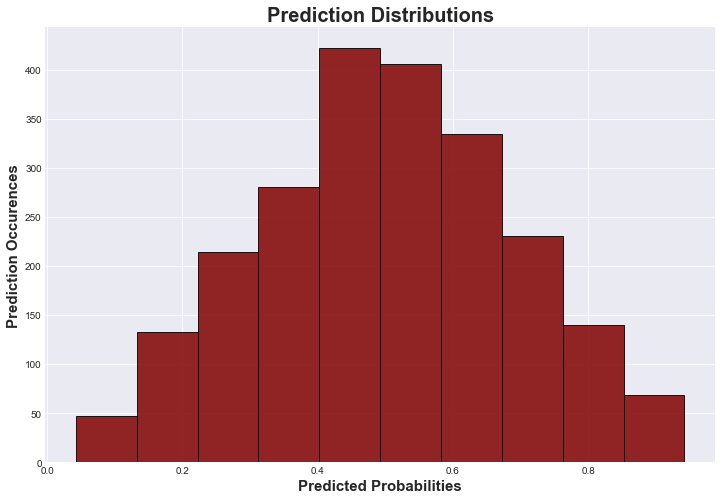

In [324]:
plt.figure(figsize=(12, 8))
plt.title('Prediction Distributions', fontsize = 20, fontweight = 'bold')
plt.xlabel('Predicted Probabilities', fontsize = 15, fontweight = 'bold')
plt.ylabel('Prediction Occurences', fontsize = 15, fontweight = 'bold')
plt.hist(submissions.Pred, bins=10, color='maroon', alpha = .85, edgecolor='k');
plt.savefig('PredictionDistributions.png')

# // Hindsight is 20/20

First I'll adjust for the results of the one play-in game my model incorrectly predicted between ASU and Syracuse.

In [325]:
teams.loc[teams.TeamName == 'Arizona St', :]

,TeamID,TeamName,FirstD1Season,LastD1Season
12,1113,Arizona St,1985,2018


In [326]:
teams.loc[teams.TeamName == 'Syracuse', :]

,TeamID,TeamName,FirstD1Season,LastD1Season
292,1393,Syracuse,1985,2018


In [327]:
submissions.loc[submissions.ID == '2018_1113_1393', :]

,ID,Pred
3352,2018_1113_1393,0.653982


In [328]:
submissions.set_value(3352, 'Pred', 0.4999)

,ID,Pred
0,2018_1104_1112,0.080061
67,2018_1104_1113,0.597357
68,2018_1112_1113,0.738149
134,2018_1104_1116,0.382128
135,2018_1112_1116,0.652082
136,2018_1113_1116,0.587313
201,2018_1104_1120,0.461294
202,2018_1112_1120,0.476311
203,2018_1113_1120,0.596957
204,2018_1116_1120,0.445451


In [329]:
submissions.to_csv('MM_submissions_2.csv', index=False)

### // Tom Cruise and Bracketology

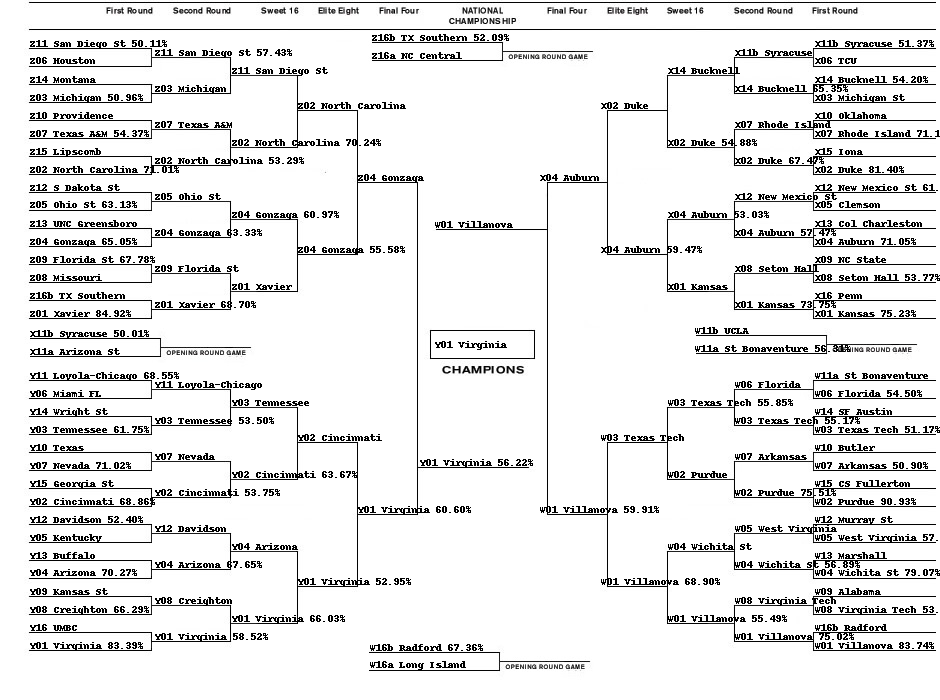

In [330]:
from bracketeer import build_bracket
b = build_bracket(
        outputPath='output.png',
        teamsPath='../Datasets/DataFiles/Teams.csv',
        seedsPath='Stage2UpdatedDataFiles/NCAATourneySeeds.csv',
        submissionPath='MM_submissions_2.csv',
        slotsPath='Stage2UpdatedDataFiles/NCAATourneySlots.csv',
        year=2018
)

from IPython.display import Image
Image("output.png")

### // So everything looks reasonable enough except for that Bucknell upset. Let's investigate.

In [331]:
rs_rf.feature_importances_

array([0.03079953, 0.05540037, 0.01994204, 0.03155341, 0.01849015,
       0.01858212, 0.01883329, 0.01940497, 0.03392523, 0.06678641,
       0.0561224 , 0.05092772, 0.01898301, 0.01814855, 0.01984896,
       0.01898022, 0.02669659, 0.06522537, 0.02218822, 0.03419866,
       0.01875569, 0.01816576, 0.01753096, 0.01890053, 0.0339886 ,
       0.05680317, 0.05393907, 0.05910929, 0.01830432, 0.01839134,
       0.02116435, 0.01990972])

In [332]:
fi = pd.DataFrame({
        'feature':train[new_features].columns,
        'importance':rs_rf.feature_importances_
    })

fi.sort_values('importance', ascending=False, inplace=True)
fi.iloc[0:5, :]

,feature,importance
9,Off_Rtg_dif_avg_x,0.066786
17,Def_Rtg_dif_avg_y,0.065225
27,PIE_dif_avg_y,0.059109
25,Off_Rtg_dif_avg_y,0.056803
10,PIE_avg_x,0.056122


In [333]:
interest_cols = list(fi.iloc[0:5,:]['feature'].values)
interest_cols_2 = ['Off_Rtg_dif_avg','Def_Rtg_dif_avg','PIE_dif_avg','Off_Rtg_dif_avg','PIE_avg']

In [334]:
# Bucknell Stats
summary_stats.loc[summary_stats.TeamID == 1137, interest_cols_2]

,Off_Rtg_dif_avg,Def_Rtg_dif_avg,PIE_dif_avg,Off_Rtg_dif_avg,PIE_avg
31,11.915957,-11.915957,0.16886,11.915957,0.58443


In [335]:
 # Michigan St stats
summary_stats.loc[summary_stats.TeamID == 1277, interest_cols_2]

,Off_Rtg_dif_avg,Def_Rtg_dif_avg,PIE_dif_avg,Off_Rtg_dif_avg,PIE_avg
169,24.142286,-24.142286,0.373193,24.142286,0.686596


In [336]:
# Specific matchup
tourney.loc[(tourney.TeamID_x == 1137) & (tourney.TeamID_y == 1277), interest_cols]

,Off_Rtg_dif_avg_x,Def_Rtg_dif_avg_y,PIE_dif_avg_y,Off_Rtg_dif_avg_y,PIE_avg_x
1948,11.915957,-24.142286,0.373193,24.142286,0.58443


# Unfinished bidness:

### The plan:

- I want to build a scraper to pull in all the team season-long average stats.
- Then put those with each regular season game so that way the model can learn from the labels (W/L).
    - This should also include location to learn who is playing better on the road / neutral.
- Also (time permitting) I want to include the mascots by weight feature to make it a little different and fun.

In [337]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from time import sleep
import re

KeyboardInterrupt: 

**Getting a list of the team names and their corresponding URLs:**

In [ ]:
res = requests.get('http://stats.ncaa.org/team/inst_team_list?academic_year=2017&conf_id=-1&division=1&sport_code=MBB')
soup = BeautifulSoup(res.content, 'lxml')

In [ ]:
giant_table = soup.find('div', {'class': 'css-panes'}).find('table')

In [ ]:
team_names = []
team_urls = []

In [ ]:
for column in giant_table.find_all('table'):
    for link in column.find_all('a'):
        team_names.append(link.text)
        team_urls.append('http://stats.ncaa.org/team' + str(link.attrs.get('href')))

**Trying to get a single team's stats:**

In [ ]:
res = requests.get('http://stats.ncaa.org/teams/42595')
soup = BeautifulSoup(res.content, 'lxml')
res.status_code

In [ ]:
stat_names = []
stat_values = []

for stat_name in soup.find_all('a', {'target': 'Rankings'}):
    stat_names.append(stat_name.text)
    
for i, x in enumerate(soup.find_all('td', {'align': 'right'})):
    if i % 2 != 0:
        stat_values.append(x.text)
        stat_values = [num.replace(" ", "") for num in stat_values]
        stat_values = [num.replace('\n', '') for num in stat_values]

**Now putting it all together into a scraper that will go into each team's URL**

In [ ]:
team_stats = []

# starting_url = 'http://stats.ncaa.org/team/inst_team_list?academic_year=2017&conf_id=-1&division=1&sport_code=MBB'

def scrape_team_stats(url_list):
    missed_url_list = []
    for team in url_list:
        
        stat_values = []

        soup = BeautifulSoup(requests.get(team).content, 'html.parser')

        for i, x in enumerate(soup.find_all('td', {'align': 'right'})):
            if i % 2 != 0:
                stat_values.append(x.text)
                stat_values = [num.replace(" ", "") for num in stat_values]
                stat_values = [num.replace('\n', '') for num in stat_values]

        if stat_values != []:
            stat_values.append(team)
            team_stats.append(stat_values)
        else:
            missed_url_list.append(team)
                
    if len(missed_url_list) == 0:
        return team_stats
    else:
        return scrape_team_stats(missed_url_list)
            
scrape_team_stats(team_urls)

**Don't forget to make a "difficulty by seed" feature!!!**

Very interesting to think about the difficulty of the path to the final that way, though I would've probably tried to weigh it by the probability that your team will face that seed in the next round instead of just assuming you will face the higher seed.

i mean use bayes - instead of saying the 5 auto plays the 4 next round say they get 12*probability 5 will win + 5* probability 12 will win